In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_wine
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### Load and Prepare Data

In [2]:
# Load dataset
data = load_wine()
X, y = data.data, data.target
feature_names = data.feature_names

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to DataFrame for visualization
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y


#### Train Gradient Boosting Classifier

In [3]:
# Initialize GBM with default parameters
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train, y_train)

# Predictions
y_pred = gbm.predict(X_test)

# Evaluate
print("GBM Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


GBM Accuracy: 0.9444444444444444
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.93      0.93      0.93        14
           2       1.00      0.90      0.95        10

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.95        36
weighted avg       0.95      0.94      0.94        36



#### Feature Importance Visualization

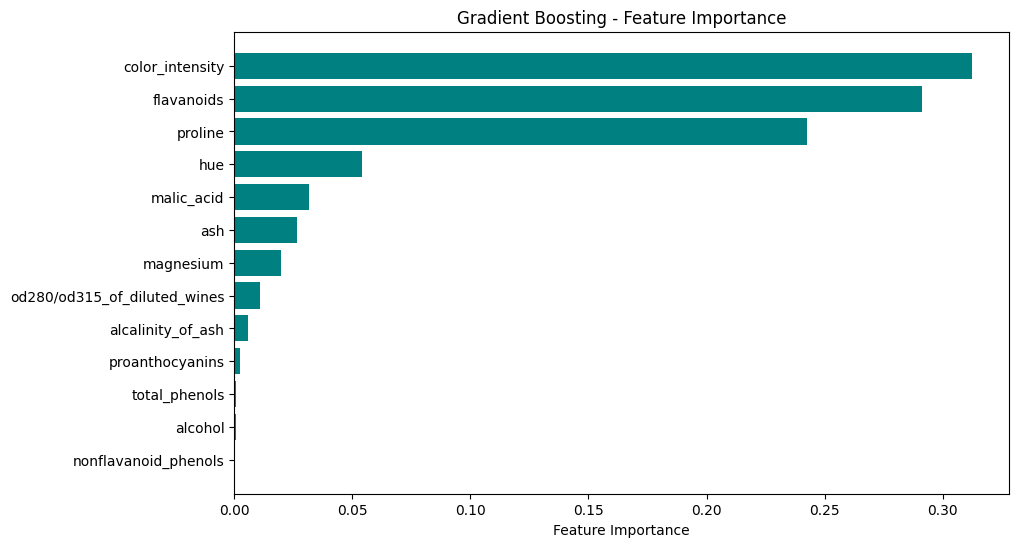

In [4]:
feature_importance = gbm.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize = (10,6))
plt.barh(np.array(feature_names)[sorted_idx], feature_importance[sorted_idx], color = 'teal')
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting - Feature Importance")
plt.show()

#### SHAP (Explainability of Model Predictions)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:40<00:00,  1.14s/it]


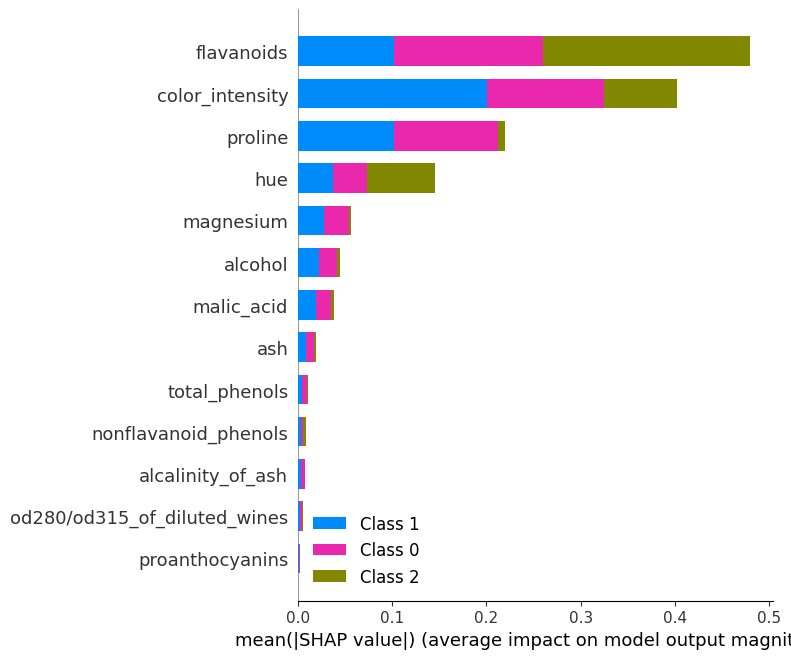

In [10]:
import shap

# Create a small sample from the training set as background data for SHAP
background = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

# Initialize KernelExplainer for multi-class classification
explainer = shap.KernelExplainer(gbm.predict_proba, background)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test[:100])  # Use a subset for efficiency

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)


#### Confusion Matrix (Error Analysis)

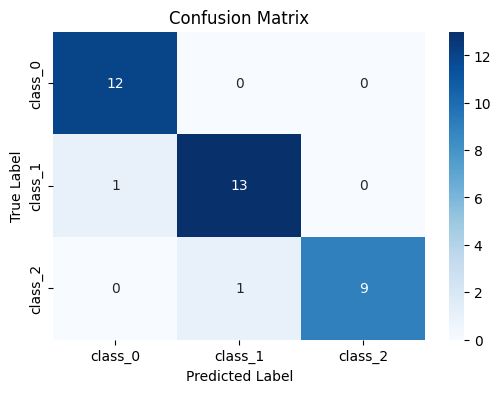

In [11]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


#### Residual Plot (Error Distribution)

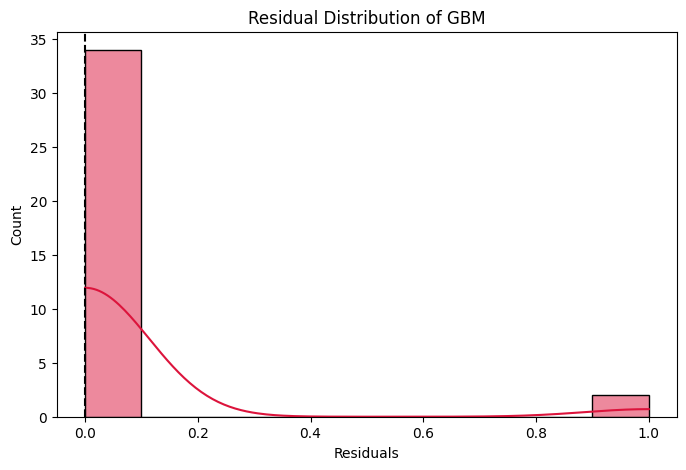

In [12]:
# Compute residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=10, kde=True, color='crimson')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel("Residuals")
plt.title("Residual Distribution of GBM")
plt.show()


#### Hyperparameter Tuning (Grid Search)

In [13]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Grid Search
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


#### Training vs. Validation Performance

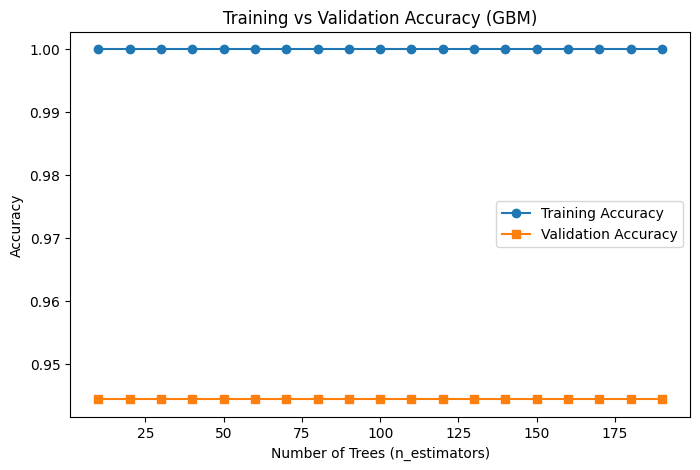

In [14]:
# Train models with increasing estimators
train_scores = []
test_scores = []
estimators = np.arange(10, 200, 10)

for n in estimators:
    model = GradientBoostingClassifier(n_estimators=n, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

# Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(estimators, train_scores, label="Training Accuracy", marker='o')
plt.plot(estimators, test_scores, label="Validation Accuracy", marker='s')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (GBM)")
plt.legend()
plt.show()
